In [5]:
import numpy as np
import xarray as xr
from pathlib import Path
from os.path import exists
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [6]:
path_god = Path('/home/jpluser/ECCO_GMSL/Data/Beckley')
output_dir_main=Path('/home/jpluser/ECCO_GMSL/Data')
output_dir_missingdata=Path('/home/jpluser/ECCO_GMSL/Data/errors/missingdata')
output_dir_orbiterror=Path('/home/jpluser/ECCO_GMSL/Data/errors/orbiterror_2cm')
output_dir_orbiterror_missingdata=Path('/home/jpluser/ECCO_GMSL/Data/errors/orbiterror_missingdata_2cm')

In [7]:
std_orbiterror=0.02 #m
fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

# Create Sample file on 1 cycle of GSFC data

In [8]:
c=500
filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
beckley=xr.open_mfdataset(filename)
beckley

<xarray.Dataset> Size: 40MB
Dimensions:            (N_Records: 602812)
Coordinates:
    lat                (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
    lon                (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
    time               (N_Records) datetime64[ns] 5MB dask.array<chunksize=(602812,), meta=np.ndarray>
Dimensions without coordinates: N_Records
Data variables:
    index              (N_Records) int16 1MB dask.array<chunksize=(602812,), meta=np.ndarray>
    reference_orbit    (N_Records) int16 1MB dask.array<chunksize=(602812,), meta=np.ndarray>
    mssh               (N_Records) float64 5MB dask.array<chunksize=(602812,), meta=np.ndarray>
    Distance_to_coast  (N_Records) float64 5MB dask.array<chunksize=(602812,), meta=np.ndarray>
    Surface_Type       (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
    Bathymetry         (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
    flag               (N_Records) int16 1MB dask.array<chunksize=(602812,), meta=np.ndarray>
    ssha               (N_Records) float64 5MB dask.array<chunksize=(602812,), meta=np.ndarray>
    mss_modified       bool 1B ...
    old_mssh           (N_Records) float64 5MB dask.array<chunksize=(602812,), meta=np.ndarray>
    old_ssha           (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                   CF-1.7, ACDD-1.3
    title:                         Integrated Multi-Mission Ocean Altimeter D...
    summary:                       Geo-registered along-track sea surface hei...
    source:                        TOPEX/Poseidon MGDR_B: Benada, J.R. 1997. ...
    processing_level:              2
    featureType:                   trajectory
    ...                            ...
    geospatial_vertical_units:     mm
    geospatial_vertical_positive:  up
    geospatial_lat_resolution:     0.05
    geospatial_lon_resolution:     2.83
    geospatial_vertical_min:       -14993
    geospatial_vertical_max:       18453

In [9]:
time=(beckley.time.values-beckley.time.values[0])
lat=beckley.lat.values
lon=beckley.lon.values
lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
orbit_nb=beckley.reference_orbit.values

In [10]:
ds = xr.Dataset({"time": (("i"), time*10**(-9)),
            "y": (("i"), lat),
            "x": (("i"),lon),
            "orbit_nb": (("i"),orbit_nb)},
            coords={"i": range(0,len(lat))})
ds['time'].attrs['unit'] = 'seconds since cycle start'
ds['x'].attrs['unit'] = 'degrees'
ds['y'].attrs['unit'] = 'degrees'
ds['orbit_nb'].attrs['unit'] = ''
ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
ds['x'].attrs['long_name'] = 'longitude'
ds['y'].attrs['long_name'] = 'latitude'
ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'
fileout=str(output_dir_main) + '/AlongTrack_sample.nc'
ds.to_netcdf(fileout)
ds

<xarray.Dataset> Size: 16MB
Dimensions:   (i: 602812)
Coordinates:
  * i         (i) int64 5MB 0 1 2 3 4 5 ... 602807 602808 602809 602810 602811
Data variables:
    time      (i) timedelta64[ns] 5MB 00:00:00 ... 00:00:00.000856657
    y         (i) float32 2MB 2.303 2.353 2.402 ... -0.4123 -0.3632 -0.3142
    x         (i) float32 2MB 100.7 100.8 100.8 100.8 ... 99.78 99.79 99.81
    orbit_nb  (i) int16 1MB 1 1 1 1 1 1 1 1 ... 127 127 127 127 127 127 127 127

# Create a file per cycle with missing data

In [11]:
for c in range(1,1043): 
#1042 stops end of 2018 (we need more than end of 2017 as Beckley starts in Sept 1992)
    filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_0500.V5_1.nc'
    beckley=xr.open_mfdataset(filename)
    orbit_nb=beckley.reference_orbit.values
    time=(beckley.time.values-beckley.time.values[0])*10**(-9)
    lat=beckley.lat.values
    lon=beckley.lon.values
    lat[:]=np.nan
    lon[:]=np.nan
    filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
    if exists(filename):
        # print(c)
        beckley=xr.open_mfdataset(filename)

        beckley=beckley.where(np.isfinite(beckley.ssha)) #change all variables to nan where ssha is nan but not coordinates
        lat=beckley.lat.values
        lon=beckley.lon.values
        lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
        ind=np.where(~np.isfinite(beckley.ssha))
        lat[ind]=np.nan
        lon[ind]=np.nan
        
    ds = xr.Dataset({"time": (("i"), time),
                "y": (("i"), lat),
                "x": (("i"),lon),
                "orbit_nb": (("i"),orbit_nb)},
                coords={"i": range(0,len(lat))})
    ds['time'].attrs['unit'] = 'seconds since cycle start'
    ds['x'].attrs['unit'] = 'degrees'
    ds['y'].attrs['unit'] = 'degrees'
    ds['orbit_nb'].attrs['unit'] = ''
    ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
    ds['x'].attrs['long_name'] = 'longitude'
    ds['y'].attrs['long_name'] = 'latitude'
    ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'

    fileout=str(output_dir_missingdata) + '/AlongTrack_sample_'+str(c).zfill(4)+'_missingdata.nc'
    ds.to_netcdf(fileout)

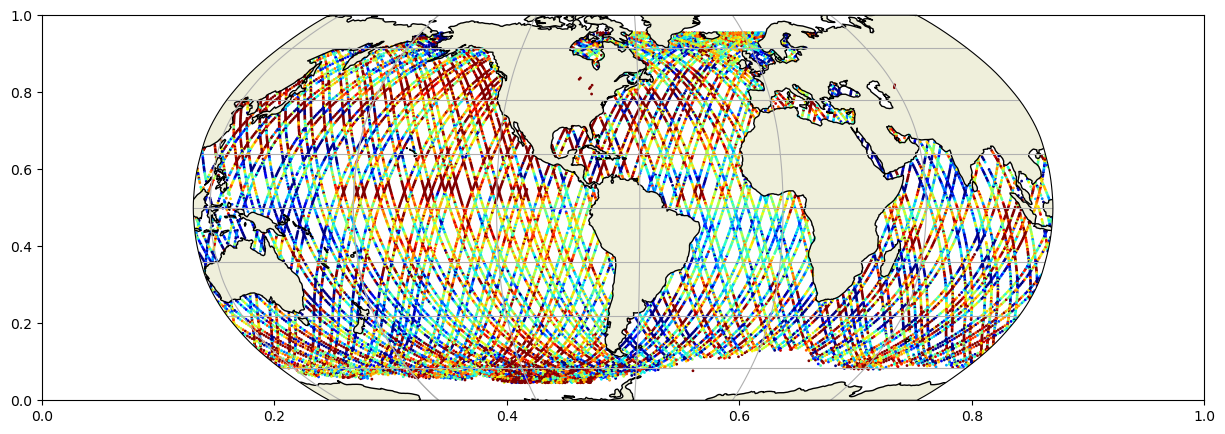

In [34]:
c=1
filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
beckley=xr.open_mfdataset(filename)
beckley=beckley.dropna(dim="N_Records", how="any")
time=beckley.time.values-beckley.time.values[0]
lat=beckley.lat.values
lon=beckley.lon.values
lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
ssh=beckley.ssha
        
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12
p=ax.scatter(lon[::kk],\
             lat[::kk], \
             c=ssh[::kk], s=1,\
             transform=ccrs.PlateCarree(),
             vmin=-100,vmax=100, cmap='jet')

# Create a file per cycle with NO missing data and parameters for orbit error

### Test

In [13]:
c=2

filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
beckley=xr.open_mfdataset(filename)

time=(beckley.time.values-beckley.time.values[0])*10**(-9)
time=time.astype(int)
lat=beckley.lat.values
lon=beckley.lon.values
lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
orbit_nb=beckley.reference_orbit.values
beckley.time

<xarray.DataArray 'time' (N_Records: 602812)> Size: 5MB
dask.array<open_dataset-time, shape=(602812,), dtype=datetime64[ns], chunksize=(602812,), chunktype=numpy.ndarray>
Coordinates:
    lat      (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
    lon      (N_Records) float32 2MB dask.array<chunksize=(602812,), meta=np.ndarray>
    time     (N_Records) datetime64[ns] 5MB dask.array<chunksize=(602812,), meta=np.ndarray>
Dimensions without coordinates: N_Records
Attributes:
    standard_name:          time
    comment:                Conversion to Modified Julian Day + fraction of d...
    coverage_content_type:  coordinate

In [14]:
period=6745 #~112 minutes for Jason 3
orbit_error=np.empty(len(orbit_nb))
orbit_error[:]=np.nan
orbit_nb_unique=np.unique(orbit_nb)

In [15]:
for i in orbit_nb_unique:
    ind=np.where(orbit_nb==i)
    amplitude=np.random.normal(0,std_orbiterror,1)
    phase=random.random()*2*np.pi
    orbit_error[ind]=amplitude*np.sin((time[ind[0]]-time[ind[0][0]])*2*np.pi/period + phase)
    # print(amplitude)

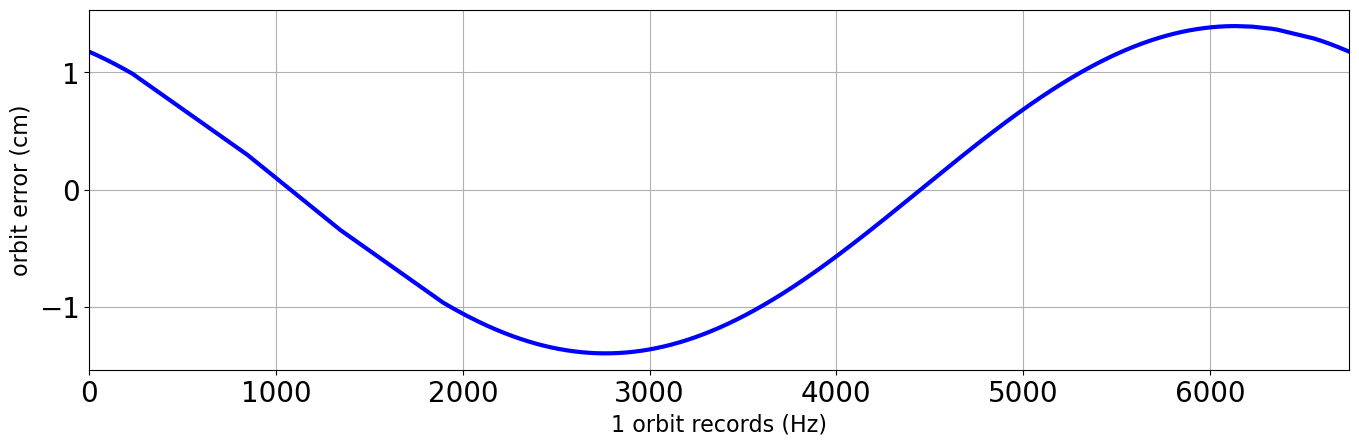

In [26]:
ind=np.where(orbit_nb==2) #tmax-tmin on that orbit is 6745 (max)
# time[ind[0][-1]]-time[ind[0][0]]
# fig = plt.figure(figsize=(15,5))
# plt.plot(time[ind],orbit_error[ind])
# plt.title('orbit error - 1 orbit')

fig,ax=plt.subplots(figsize=(15,5))
plt.plot(time[ind]-time[ind[0][0]],orbit_error[ind]*100,color='b',linestyle='-',linewidth=3)
plt.grid()
# plt.ylim([-8,4])
plt.tick_params(axis='both', which='major', labelsize =20)
ax.set_ylabel('orbit error (cm)',fontsize=16)
ax.set_xlabel('1 orbit records (Hz)',fontsize=16)
ax.set_xlim([0, time[ind[0][-1]]-time[ind[0][0]]])
plt.title('')
ax.tick_params(axis='both', which='major', labelsize =20)
plt.subplots_adjust(left=0.13,top=0.93,bottom=0.21,right=0.97)
plt.savefig(fig_dir / 'ts_orbiterror_1pass.png',dpi=200,transparent=False,facecolor='white')

Text(0.5, 1.0, 'orbit error - 1 orbit')

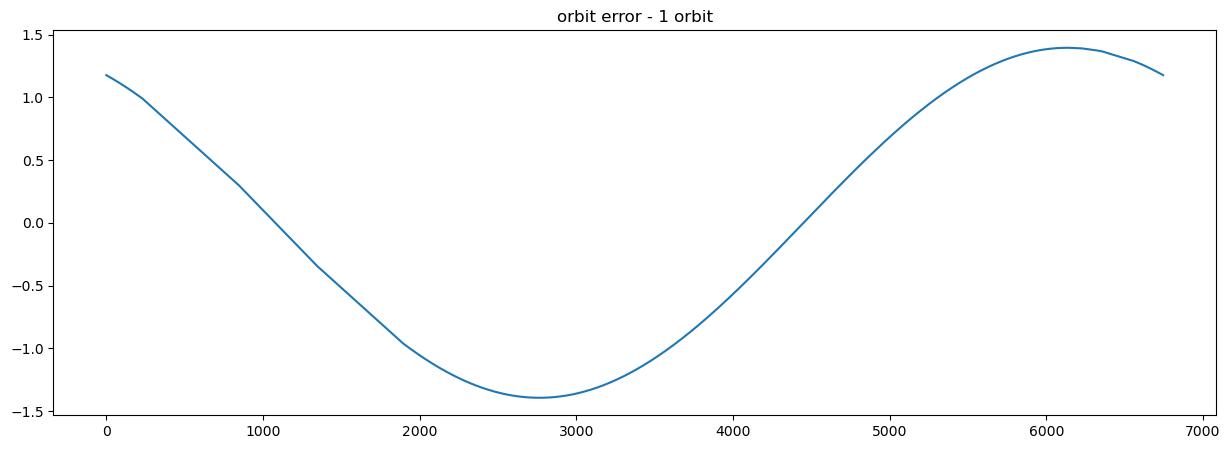

In [27]:
ind=np.where(orbit_nb==2) #tmax-tmin on that orbit is 6100
fig = plt.figure(figsize=(15,5))
plt.plot(time[ind]-time[ind[0][0]],orbit_error[ind]*100)
plt.title('orbit error - 1 orbit')

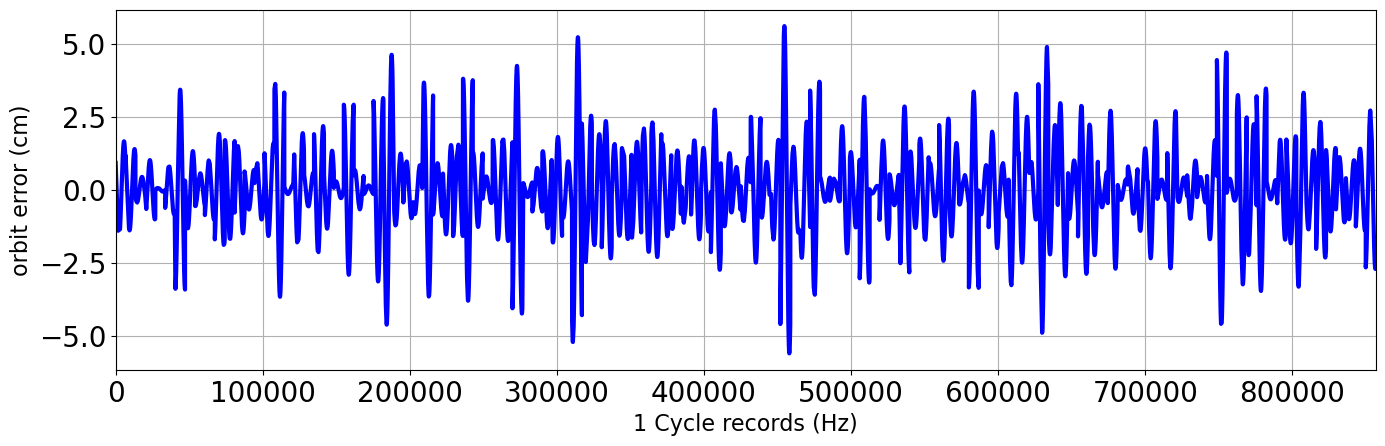

In [18]:
# fig = plt.figure(figsize=(15,5))
# plt.plot(orbit_error)
# plt.title('orbit error - 1 cycle')

fig,ax=plt.subplots(figsize=(15,5))
plt.plot(time,orbit_error*100,color='b',linestyle='-',linewidth=3)
plt.grid()
# plt.ylim([-8,4])
plt.tick_params(axis='both', which='major', labelsize =20)
ax.set_ylabel('orbit error (cm)',fontsize=16)
ax.set_xlabel('1 Cycle records (Hz)',fontsize=16)
ax.set_xlim([0, time[-1]])
plt.title('')
ax.tick_params(axis='both', which='major', labelsize =20)
plt.subplots_adjust(left=0.13,top=0.93,bottom=0.21,right=0.97)
plt.savefig(fig_dir / 'ts_orbiterror_1cycle.png',dpi=200,transparent=False,facecolor='white')

### All time series

In [35]:
period=6745 #~112 minutes for Jason 3
filename=str(path_god)+'/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_0500.V5_1.nc' #we use the same cycle over and over as in the sample file but the orbit error changes in each orbit and each cycle
beckley=xr.open_mfdataset(filename)
for c in range(1,1043): #cycle Goddard: c+862 (cycle 521 missing)
    # print(c)
    time=(beckley.time.values-beckley.time.values[0])*10**(-9)
    lat=beckley.lat.values
    lon=beckley.lon.values
    lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
    orbit_nb=beckley.reference_orbit.values

    orbit_error=np.empty(len(orbit_nb))
    orbit_error[:]=np.nan
    orbit_nb_unique=np.unique(orbit_nb)
    for i in orbit_nb_unique:
        ind=np.where(orbit_nb==i)
        amplitude=np.random.normal(0,std_orbiterror,1)
        phase=random.random()*2*np.pi
        orbit_error[ind]=amplitude*np.sin((time.astype(int)[ind[0]]-time.astype(int)[ind[0][0]])*2*np.pi/period + phase)

    ds = xr.Dataset({"time": (("i"), time),
                "y": (("i"), lat),
                "x": (("i"),lon),
                "orbit_nb": (("i"),orbit_nb),
                "orbit_error": (("i"),orbit_error)},
                coords={"i": range(0,len(lat))})
    ds['time'].attrs['unit'] = 'seconds since cycle start'
    ds['x'].attrs['unit'] = 'degrees'
    ds['y'].attrs['unit'] = 'degrees'
    ds['orbit_nb'].attrs['unit'] = ''
    ds['orbit_error'].attrs['unit'] = 'cm'
    ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
    ds['x'].attrs['long_name'] = 'longitude'
    ds['y'].attrs['long_name'] = 'latitude'
    ds['orbit_error'].attrs['long_name'] = 'orbit error = amplitude * sin(2 pi t/T + phase)'
    ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'

    fileout=str(output_dir_orbiterror) + '/AlongTrack_sample_'+str(c).zfill(4)+'_orbiterror.nc'
    ds.to_netcdf(fileout)

# Create a file per cycle with missing data AND parameters for orbit error

In [36]:
period=6745 #~112 minutes for Jason 3
for c in range(1,1043): #cycle Goddard: c+862 (cycle 521 missing)
    filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_0500.V5_1.nc'
    beckley=xr.open_mfdataset(filename)
    orbit_nb=beckley.reference_orbit.values
    time=(beckley.time.values-beckley.time.values[0])*10**(-9)
    lat=beckley.lat.values
    lon=beckley.lon.values
    lat[:]=np.nan
    lon[:]=np.nan
    
    filename=str(path_god)+'/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
    if exists(filename):
        # print(c)
        beckley=xr.open_mfdataset(filename)

        beckley=beckley.where(np.isfinite(beckley.ssha))
        lat=beckley.lat.values
        lon=beckley.lon.values
        lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
        ind=np.where(~np.isfinite(beckley.ssha))
        lat[ind]=np.nan
        lon[ind]=np.nan
        
        orbit_error=np.empty(len(orbit_nb))
        orbit_error[:]=np.nan
        orbit_nb_unique=np.unique(orbit_nb)
        for i in orbit_nb_unique:
            ind=np.where(orbit_nb==i)
            amplitude=np.random.normal(0,std_orbiterror,1)
            phase=random.random()*2*np.pi
            orbit_error[ind]=amplitude*np.sin((time.astype(int)[ind[0]]-time.astype(int)[ind[0][0]])*2*np.pi/period + phase)
        
    ds = xr.Dataset({"time": (("i"), time),
                "y": (("i"), lat),
                "x": (("i"),lon),
                "orbit_nb": (("i"),orbit_nb),
                "orbit_error": (("i"),orbit_error)},
                coords={"i": range(0,len(lat))})
    ds['time'].attrs['unit'] = 'seconds since cycle start'
    ds['x'].attrs['unit'] = 'degrees'
    ds['y'].attrs['unit'] = 'degrees'
    ds['orbit_nb'].attrs['unit'] = ''
    ds['orbit_error'].attrs['unit'] = 'cm'
    ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
    ds['x'].attrs['long_name'] = 'longitude'
    ds['y'].attrs['long_name'] = 'latitude'
    ds['orbit_error'].attrs['long_name'] = 'orbit error = amplitude * sin(2 pi t/T + phase)'
    ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'

    fileout=str(output_dir_orbiterror_missingdata) + '/AlongTrack_sample_'+str(c).zfill(4)+'_orbiterror_missingdata.nc'
    ds.to_netcdf(fileout)   